In [1]:
import numpy as np
from tqdm import tqdm
from librosa.sequence import dtw

#import pyvista as pv
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy import ndimage

cmap, interp = 'Accent', 'bicubic'

In [2]:
# facies = np.zeros((318, 256, 256, 128))
# for i in tqdm(range(318)):
#     facies[i] = np.load('data/facies/facies_{}.npy'.format(i))

facies = np.load('data/facies.npy')
print('Facies: {}'.format(facies.shape))

In [28]:
sample = 100
# d = ndimage.gaussian_filter(facies[sample], sigma=2/3)
d = facies[sample]
print('Sample: {}'.format(sample))

Sample: 100


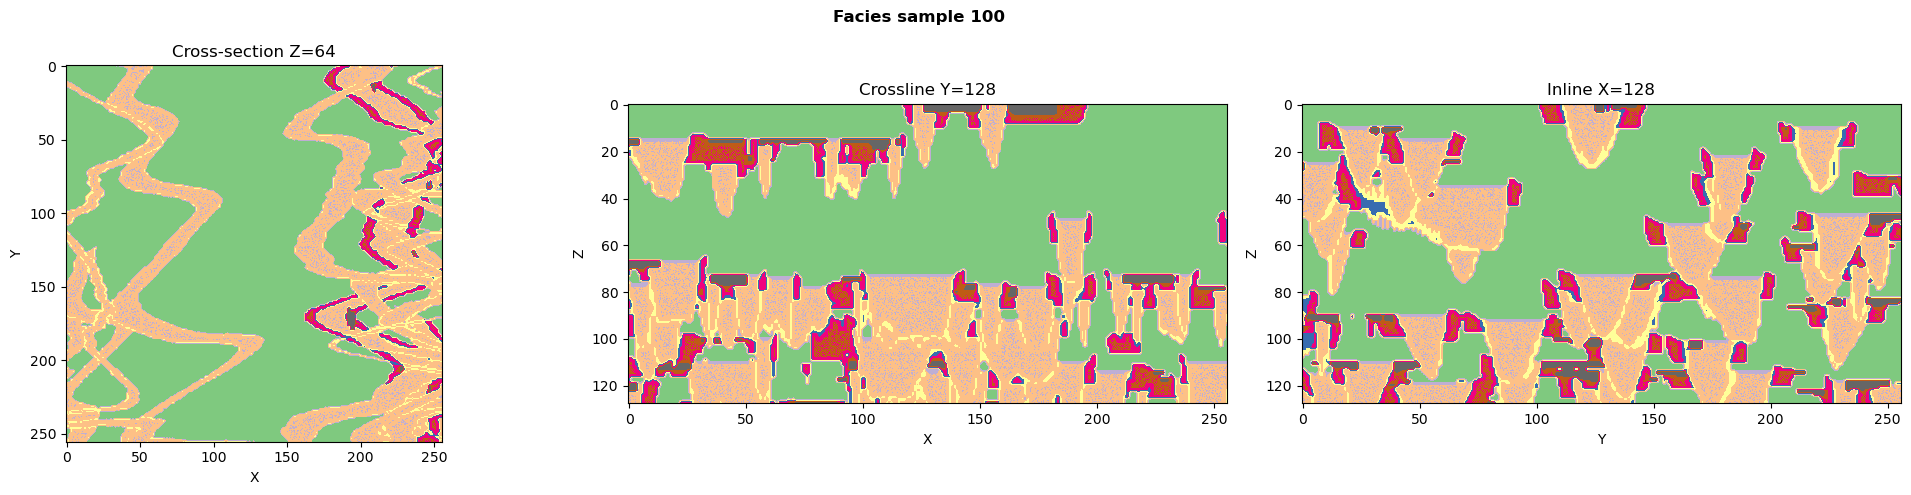

In [29]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.imshow(d[:,:,64], cmap=cmap, interpolation=interp)
plt.title('Cross-section Z=64')
plt.xlabel('X'); plt.ylabel('Y')

plt.subplot(132)
plt.imshow(d[:,128,:].T, cmap=cmap, interpolation=interp)
plt.title('Crossline Y=128')
plt.xlabel('X'); plt.ylabel('Z')

plt.subplot(133)
plt.imshow(d[128,:,:].T, cmap=cmap, interpolation=interp)
plt.title('Inline X=128')
plt.xlabel('Y'); plt.ylabel('Z')

plt.suptitle('Facies sample {}'.format(sample), weight='bold')
plt.tight_layout()
#plt.savefig('figures/xyz-maps.png', dpi=600)
plt.show()

In [30]:
# ### 3D Visualization ###
# p = pv.Plotter()
# mesh = pv.wrap(np.flip(d))

# m1 = mesh.slice_orthogonal()
# p.add_mesh(m1, cmap=cmap)

# p.show(jupyter_backend='static')

In [31]:
nw = 5

depth = np.arange(d.shape[-1]) + 1000
wx, wy = np.random.randint(15, 239, size=(2,nw))
well_log = d[wy, wx, :]
noise_log = d[wy, wx, :] + np.random.normal(0, 0.25*d.std(), d.shape[-1])

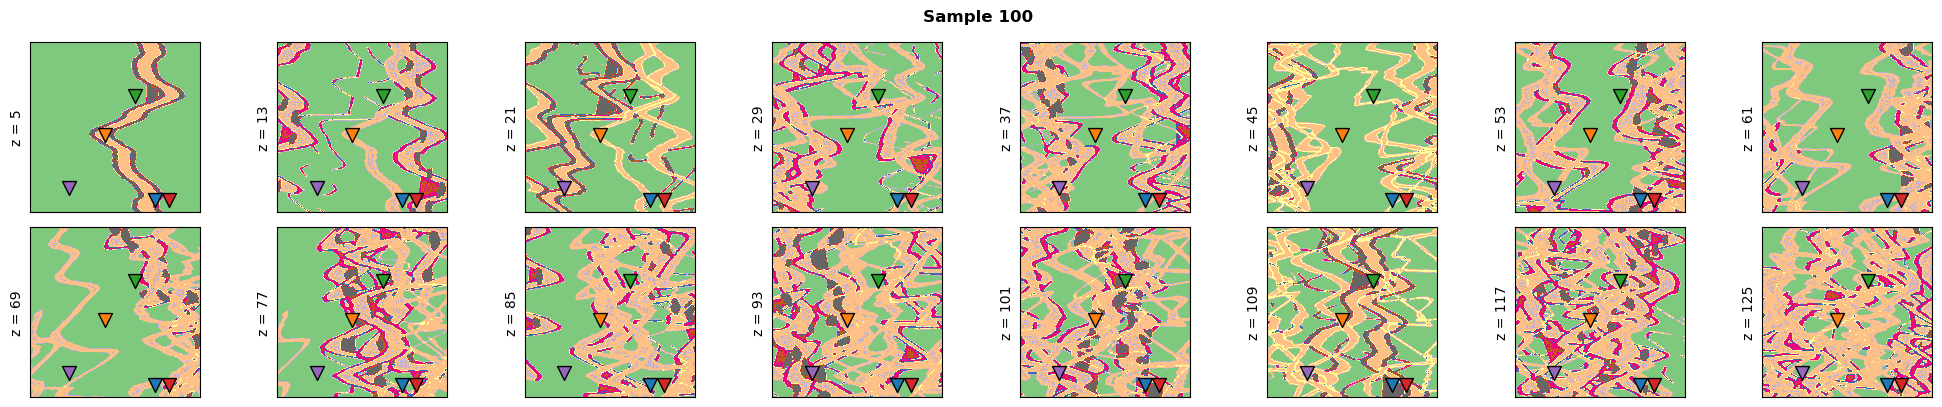

In [32]:
plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(3, 8, i+1)
    k = i * 8 + 5
    plt.imshow(d[...,k], cmap=cmap, interpolation=interp)
    [plt.scatter(wx[i], wy[i], marker='v', edgecolor='k', c='C{}'.format(i), s=100) for i in range(nw)]
    plt.xticks([]); plt.yticks([])
    plt.ylabel('z = {}'.format(k))
plt.suptitle('Sample {}'.format(sample), weight='bold')
plt.tight_layout()
#plt.savefig('figures/aerial-wells.png', dpi=600)
plt.show()

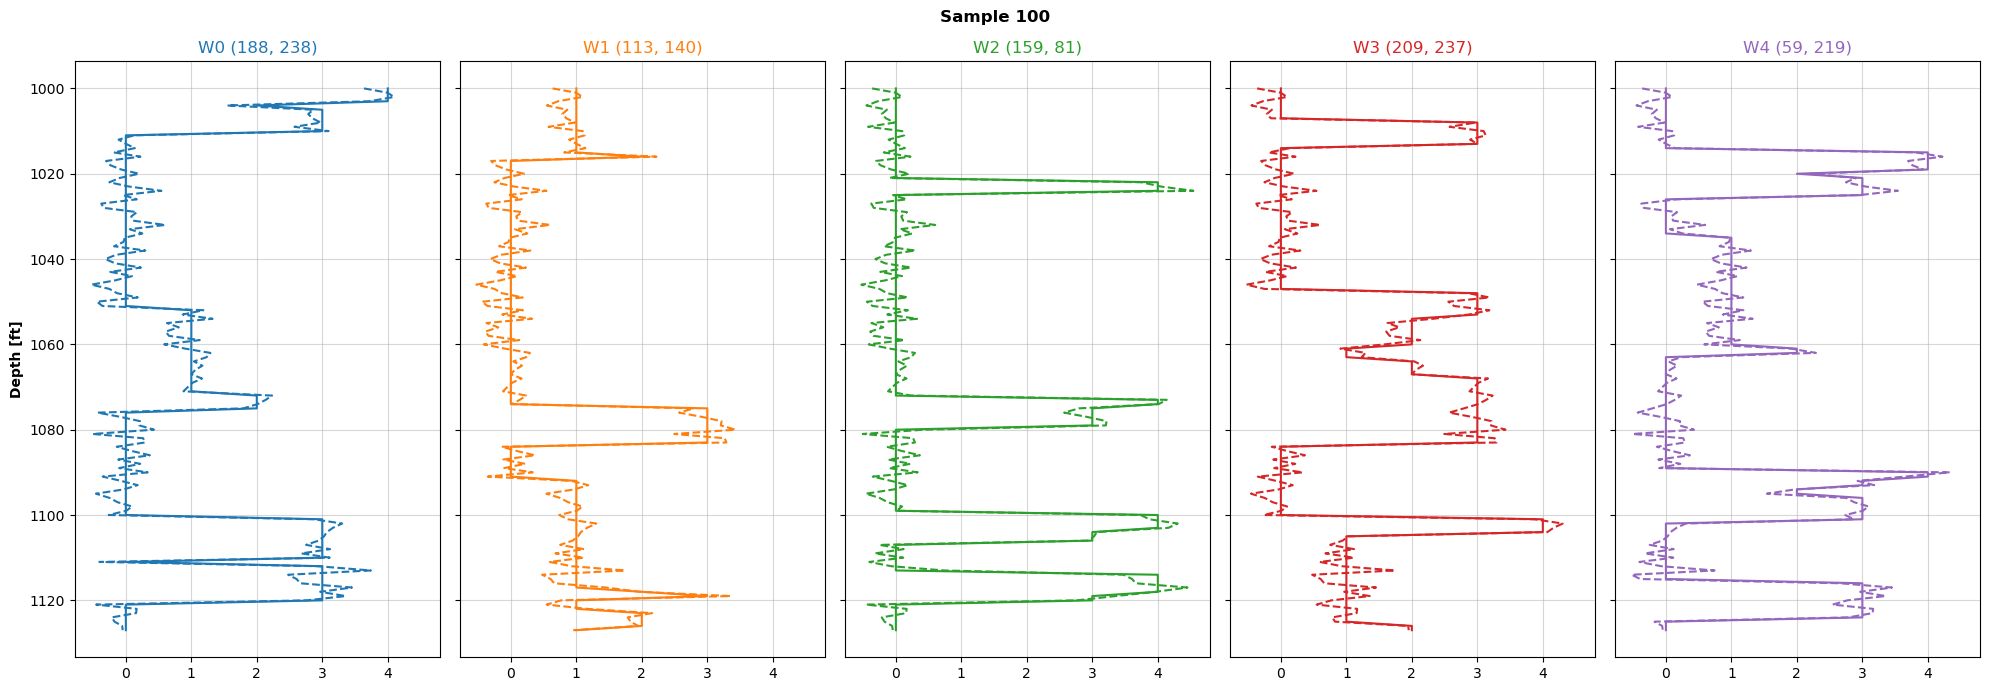

In [33]:
fig, axs = plt.subplots(1, nw, figsize=(20, 7), sharex=True, sharey=True)
for i, (x, y) in enumerate(zip(wx, wy)):
    axs[i].plot(well_log[i], depth, c='C{}'.format(i))
    axs[i].plot(noise_log[i], depth, c='C{}'.format(i), ls='--')
    axs[i].set_title('W{} ({}, {})'.format(i, x, y), color='C{}'.format(i))
    axs[i].grid(True, which='both', alpha=0.5)
    #axs[i].set(xticks=np.arange(6), xticklabels=np.arange(6), xlabel='Facies (rock class)')
axs[0].invert_yaxis()
axs[0].set_ylabel('Depth [ft]', weight='bold')
plt.suptitle('Sample {}'.format(sample), weight='bold')
plt.tight_layout()
#plt.savefig('figures/logs.png', dpi=600)
plt.show()

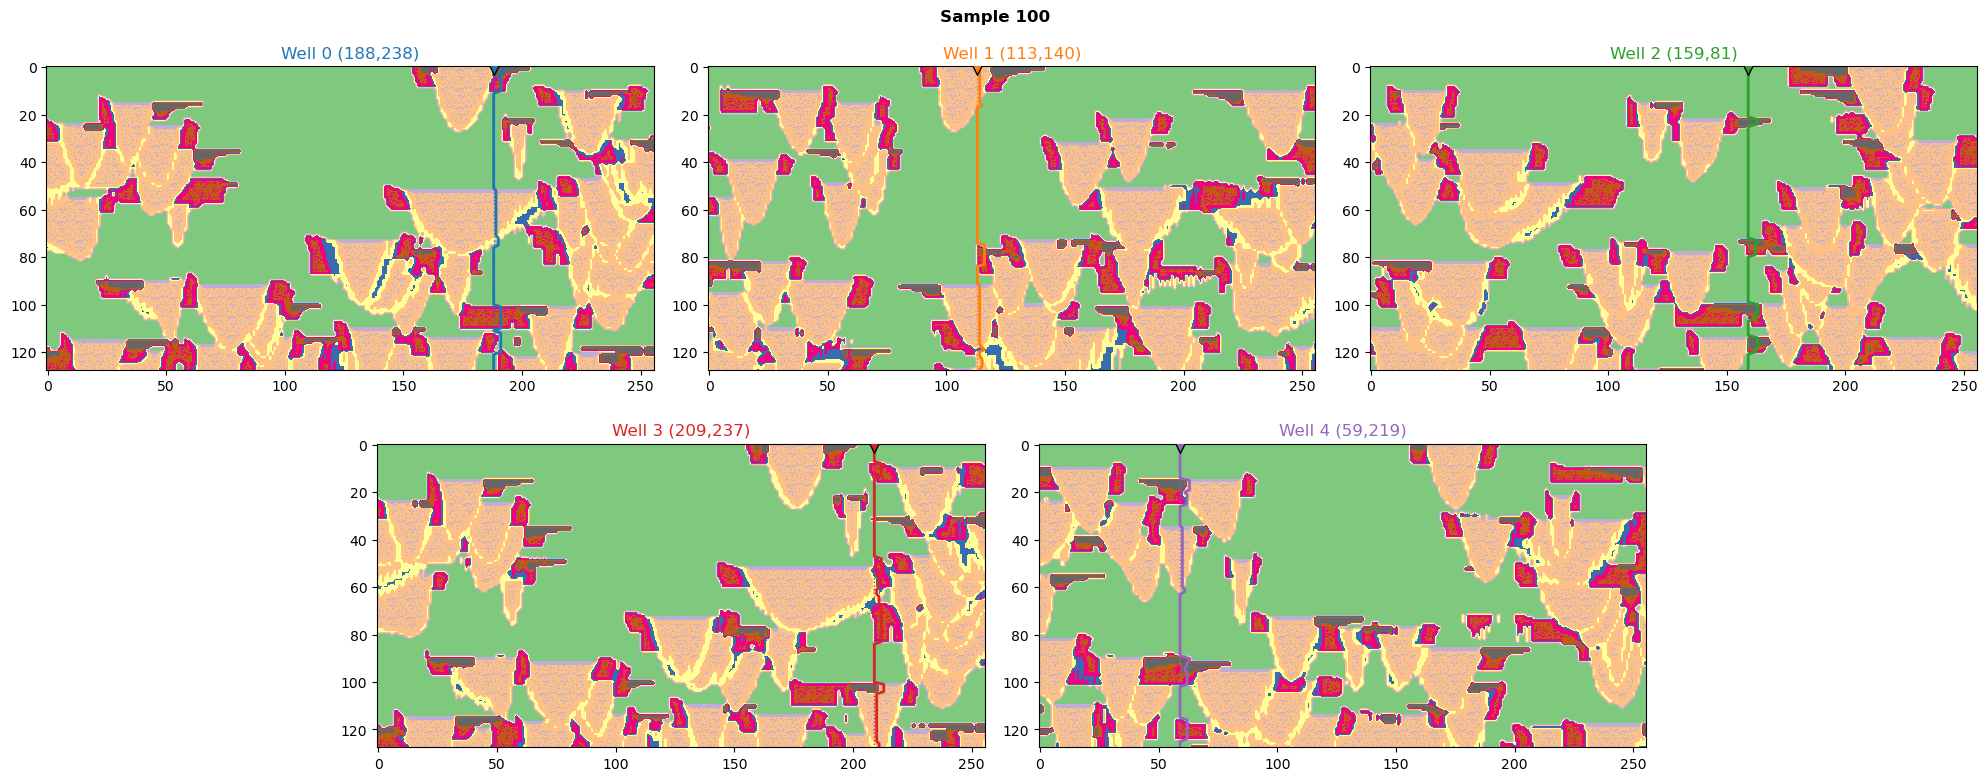

In [34]:
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 6, figure=fig)
ax1 = fig.add_subplot(gs[0, :2]) 
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:])
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])
axs = [ax1, ax2, ax3, ax4, ax5]

for i, ax in enumerate(axs):
    ax.set_title('Well {} ({},{})'.format(i, wx[i], wy[i]), color='C{}'.format(i))
    ax.imshow(d[wy[i]].T, cmap=cmap, interpolation=interp)
    ax.scatter(wx[i], 0, c='C{}'.format(i), marker='v', edgecolor='k', s=125, zorder=9)
    ax.plot(np.repeat(wx[i], 128), np.arange(128), c='C{}'.format(i), lw=1, ls=':')
    ax.plot(np.repeat(wx[i], 128)+well_log[i], np.arange(128), c='C{}'.format(i), lw=2)
plt.suptitle('Sample {}'.format(sample), weight='bold')
plt.tight_layout()
#plt.savefig('figures/logs-xsection.png', dpi=600)
plt.show()

***
### Dynamic Time Warping for Well Log Correlation

In [35]:
def plot_correlation(log1, log2, wp, d1=None, d2=None, step:int=5, figsize=(5,7), wspace=5, colors=['C0', 'C1'], cmap='Accent'):
    colormap = mpl.colormaps.get_cmap(cmap)
    lb = np.min([log1.min(), log2.min()])-0.5
    d1 = depth if d1 is None else d1
    d2 = depth if d2 is None else d2
    p, q = wp[:,0], wp[:,1]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    ax.plot(log1,          d1-np.min(d1), c=colors[0])
    ax.plot(log2 + wspace, d2-np.min(d2), c=colors[1])
    
    for i in range(0, len(p)-step, step):
        
        # intervals for log on the left:
        depth1_base = d1[p[i]]-np.min(d1)
        depth1_top = d1[p[i+step]]-np.min(d1)
        if p[i+step] < p[i]:
            mean_log1 = np.mean(log1[p[i+step]: p[i]])
            fillcolor = colormap(mean_log1)
            x = [lb, wspace-1, wspace-1, lb]
            y = [depth1_base, depth1_base, depth1_top, depth1_top]
            plt.fill(x, y, color=fillcolor)
            plt.plot([0, 0], [depth1_base, depth1_top], c='k', lw=0.5, ls=':')
        else:
            mean_log1 = log1[p[i]]

        # intervals for log on the right:
        depth2_base = d2[q[i]]-np.min(d2)
        depth2_top = d2[q[i+step]]-np.min(d2)
        if q[i+step] < q[i]:  
            mean_log2 = np.mean(log2[q[i+step]: q[i]])
            fillcolor = colormap(mean_log2)
            x = [wspace, wspace+wspace, wspace+wspace, wspace]
            y = [depth2_base, depth2_base, depth2_top, depth2_top]
            plt.fill(x, y, color=fillcolor)
            plt.plot([wspace, wspace], [depth2_base, depth2_top], c='k', lw=0.5, ls=':')
        else:
            mean_log2 = log2[q[i]]

        # intervals between the two logs:
        if (p[i+step] < p[i]) or (q[i+step] < q[i]):
            mean_logs = (mean_log1 + mean_log2)/2
            fillcolor = colormap(mean_logs)
            x = [wspace-1, wspace, wspace, wspace-1]
            y = [depth1_base, depth2_base, depth2_top, depth1_top]
            plt.fill(x, y, color=fillcolor)
            plt.plot([wspace-1, wspace-1], [depth1_top, depth1_base], c='k', lw=0.5, ls=':')

    plt.xticks([])
    plt.xlim(lb, wspace*2)
    plt.yticks(np.arange(0, len(depth), 20), depth[::20])
    plt.ylabel('depth (ft)')
    plt.ylim(0, len(d1))

    plt.gca().invert_yaxis()
    return None

D: (128, 128) | wp: (147, 2)


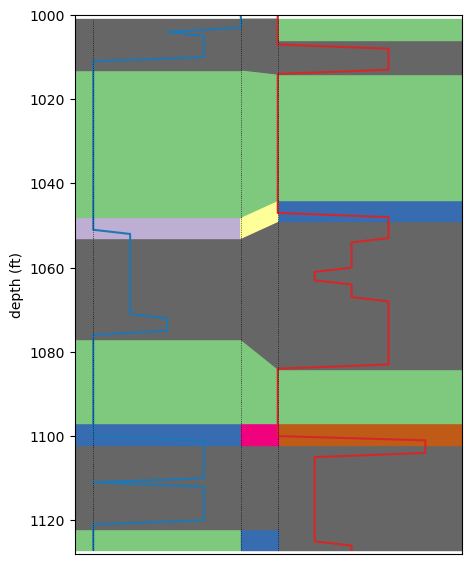

In [54]:
w1, w2 = well_log[0], well_log[3]

D, wp = dtw(w1, w2)
print('D: {} | wp: {}'.format(D.shape, wp.shape))
plot_correlation(w1, w2, wp, colors=['C0', 'C3'])

***
# END